<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />


# Table of Contents
In this lab, you will study convolution and review how the different operations change the relationship between input and output.

<div class="alert alert-block alert-info" style="margin-top: 20px">
<li><a href="#ref0">Multiple Output Channels </a></li>

<li><a href="#ref1">Multiple Inputs</a></li>
<li><a href="#ref2">Multiple Input and Multiple Output Channels </a></li>
<li><a href="#ref3">Practice Questions </a></li>

<br>
<p></p>
Estimated Time Needed: <strong>25 min</strong>
</div>

<hr>

Import the following libraries:

In [1]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage, misc

<a id="ref0"></a>
<h2 align=center>Multiple Output Channels </h2>

In Pytroch, you can create a <code>Conv2d</code> object with multiple outputs. For each channel, a kernel is created, and each kernel performs a convolution independently. As a result, the number of outputs is equal to the number of channels. This is demonstrated in the following figure. The number 9 is convolved with three kernels: each of a different color. There are three different activation maps represented by the different colors.

<img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.1.2activationmaps.png" width = 750, align = "center">

Symbolically, this can be represented as follows:

<img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.1.2activationmap2.png" width = 500, align = "center">

Create a <code>Conv2d</code> with three channels:

In [2]:
conv1 = nn.Conv2d(in_channels=1, out_channels=3,kernel_size=3)

Pytorch randomly assigns values to each kernel. However, use kernels that have  been developed to detect edges:

In [3]:
Gx=torch.tensor([[1.0,0,-1.0],[2.0,0,-2.0],[1.0,0.0,-1.0]])
Gy=torch.tensor([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]])

conv1.state_dict()['weight'][0][0]=Gx
conv1.state_dict()['weight'][1][0]=Gy
conv1.state_dict()['weight'][2][0]=torch.ones(3,3)

Each kernel has its own bias, so set them all to zero:

In [4]:
conv1.state_dict()['bias'][:]=torch.tensor([0.0,0.0,0.0])
conv1.state_dict()['bias']

tensor([0., 0., 0.])

Print out each kernel: 

In [5]:
for x in conv1.state_dict()['weight']:
    print(x)

tensor([[[ 1.,  0., -1.],
         [ 2.,  0., -2.],
         [ 1.,  0., -1.]]])
tensor([[[ 1.,  2.,  1.],
         [ 0.,  0.,  0.],
         [-1., -2., -1.]]])
tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]])


Create an input <code>image</code> to represent the input X:

In [6]:
image=torch.zeros(1,1,5,5)
image[0,0,:,2]=1
image

tensor([[[[0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.]]]])

Plot it as an image: 

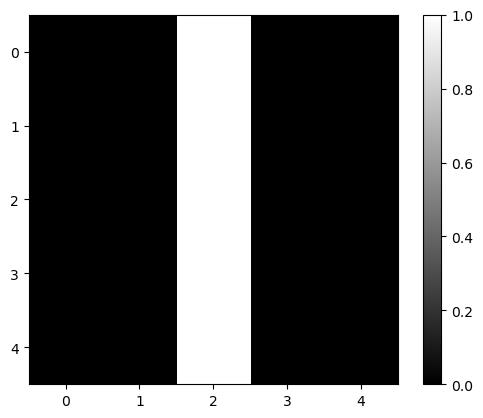

In [7]:
plt.imshow(image[0,0,:,:].numpy(), interpolation='nearest', cmap=plt.cm.gray)
plt.colorbar()
plt.show()

Perform convolution using each channel: 

In [8]:
out=conv1(image)

The result is a 1x3x3x3 tensor. This represents one sample with three channels, and each channel contains a 3x3 image.  The same rules that govern the shape of each image were discussed in the last section.

In [9]:
out.shape

torch.Size([1, 3, 3, 3])

Print out each channel as a tensor or an image: 

tensor([[-4.,  0.,  4.],
        [-4.,  0.,  4.],
        [-4.,  0.,  4.]], grad_fn=<UnbindBackward0>)


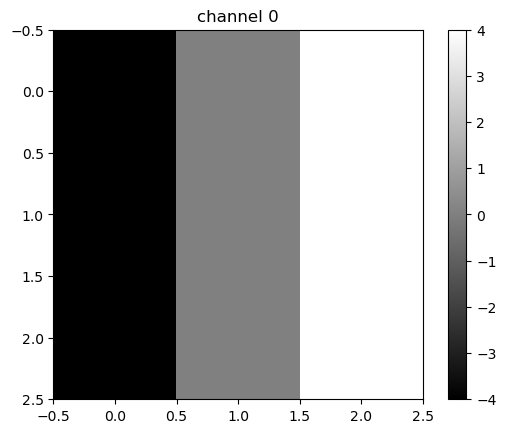

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<UnbindBackward0>)


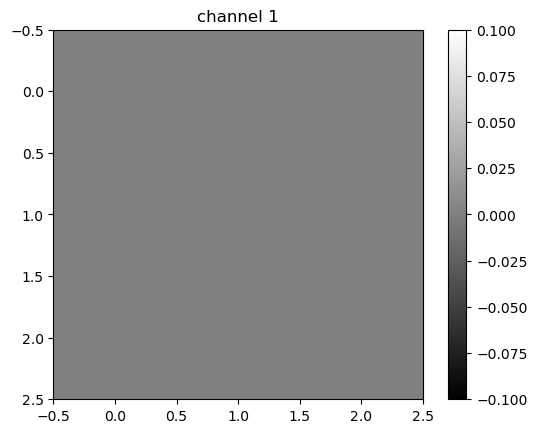

tensor([[3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.]], grad_fn=<UnbindBackward0>)


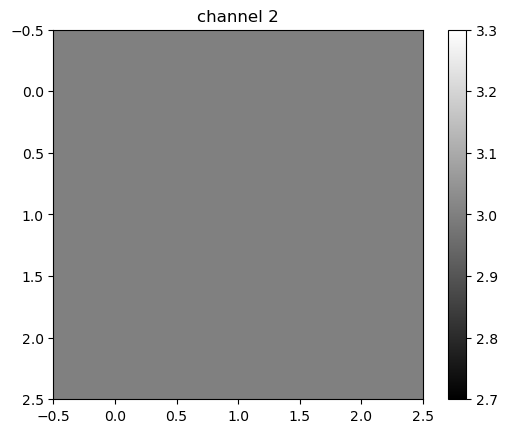

In [10]:
for channel,image in enumerate(out[0]):
    plt.imshow(image.detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
    print(image)
    plt.title("channel {}".format(channel))
    plt.colorbar()
    plt.show()

Different kernels can be used to detect various features in an image. You can see that the first channel fluctuates, and the second two channels produce a constant value. The following figure summarizes the process:

<img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.1.2outputsgray.png" width = 750, align = "center">

If you use a different image, the result will be different: 

In [ ]:
image1=torch.zeros(1,1,5,5)
image1[0,0,2,:]=1
print(image1)
plt.imshow(image1[0,0,:,:].detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
plt.show()

In this case, the second channel fluctuates, and the first and the third channels produce a constant value.

In [ ]:
out1=conv1(image1)
for channel,image in enumerate(out1[0]):
    plt.imshow(image.detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
    print(image)
    plt.title("channel {}".format(channel))
    plt.colorbar()
    plt.show()

The following figure summarizes the process:

<img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.1.2ouputsgray2.png" width = 750, align = "center">

<a id="ref1"></a>
<h2 align=center>Multiple Input Channels </h2>

For two inputs, you can create two kernels. Each kernel performs a convolution on its associated input channel. The resulting output is added together as shown:  

<img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.1.22chanalsinput.png" width = 750, align = "center">

Create an input with two channels:

In [ ]:
image2=torch.zeros(1,2,5,5)
image2[0,0,2,:]=-2
image2[0,1,2,:]=1
image2

Plot out each image: 

In [ ]:
for channel,image in enumerate(image2[0]):
    plt.imshow(image.detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
    print(image)
    plt.title("channel {}".format(channel))
    plt.colorbar()
    plt.show()

Create a <code>Conv2d</code> object with two inputs:

In [ ]:
conv3 = nn.Conv2d(in_channels=2, out_channels=1,kernel_size=3)

Assign kernel values to make the math a little easier: 

In [ ]:
Gx1=torch.tensor([[0.0,0.0,0.0],[0,1.0,0],[0.0,0.0,0.0]])
conv3.state_dict()['weight'][0][0]=1*Gx1
conv3.state_dict()['weight'][0][1]=-2*Gx1
conv3.state_dict()['bias'][:]=torch.tensor([0.0])

In [ ]:
conv3.state_dict()['weight']

Perform the convolution:

In [ ]:
conv3(image2)

The following images summarize the process. The object performs Convolution.

<img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.1.2_two_channal_example.png" width = 750, align = "center">

Then, it adds the result: 

<img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.1.2_two_channal_example2.png" width = 750, align = "center">

<a id="ref2"></a>

<h2>Multiple Input and Multiple Output Channels</h2>


When using multiple inputs and outputs, a kernel is created for each input, and the process is repeated for each output. The process is summarized in the following image. 

There are two input channels and 3 output channels. For each channel, the input in red and purple is convolved with an individual kernel that is colored differently. As a result, there are three outputs. 

<img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.1.2mulit_input_output.png" width = 750, align = "center">

Create an example with two inputs and three outputs and assign the kernel values to make the math a little easier: 

In [ ]:
conv4 = nn.Conv2d(in_channels=2, out_channels=3,kernel_size=3)
conv4.state_dict()['weight'][0][0]=torch.tensor([[0.0,0.0,0.0],[0,0.5,0],[0.0,0.0,0.0]])
conv4.state_dict()['weight'][0][1]=torch.tensor([[0.0,0.0,0.0],[0,0.5,0],[0.0,0.0,0.0]])


conv4.state_dict()['weight'][1][0]=torch.tensor([[0.0,0.0,0.0],[0,1,0],[0.0,0.0,0.0]])
conv4.state_dict()['weight'][1][1]=torch.tensor([[0.0,0.0,0.0],[0,-1,0],[0.0,0.0,0.0]])

conv4.state_dict()['weight'][2][0]=torch.tensor([[1.0,0,-1.0],[2.0,0,-2.0],[1.0,0.0,-1.0]])
conv4.state_dict()['weight'][2][1]=torch.tensor([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]])

For each output, there is a bias, so set them all to zero: 

In [ ]:
conv4.state_dict()['bias'][:]=torch.tensor([0.0,0.0,0.0])

Create a two-channel image and plot the results: 

In [ ]:
image4=torch.zeros(1,2,5,5)
image4[0][0]=torch.ones(5,5)
image4[0][1][2][2]=1
for channel,image in enumerate(image4[0]):
    plt.imshow(image.detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
    print(image)
    plt.title("channel {}".format(channel))
    plt.colorbar()
    plt.show()

Perform the convolution:

In [ ]:
z=conv4(image4)
z

The output of the first channel is given by: 

<img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.1.2_%20multi_channel_1.png" width = 750, align = "center">

The output of the second channel is given by:

<img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.1.2_%20multi_channel_2.png" width = 750, align = "center">

The output of the third channel is given by: 

<img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.1.2_%20multi_channel_3.png" width = 750, align = "center">

<a id="ref3"></a>

<h2>Practice Questions </h2>

Use the following two convolution objects to produce the same result as two input channel convolution on imageA and imageB as shown in the following image:

In [ ]:
imageA=torch.zeros(1,1,5,5)
imageB=torch.zeros(1,1,5,5)
imageA[0,0,2,:]=-2
imageB[0,0,2,:]=1


conv5 = nn.Conv2d(in_channels=1, out_channels=1,kernel_size=3)
conv6 = nn.Conv2d(in_channels=1, out_channels=1,kernel_size=3)


Gx1=torch.tensor([[0.0,0.0,0.0],[0,1.0,0],[0.0,0.0,0.0]])
conv5.state_dict()['weight'][0][0]=1*Gx1
conv6.state_dict()['weight'][0][0]=-2*Gx1
conv5.state_dict()['bias'][:]=torch.tensor([0.0])
conv6.state_dict()['bias'][:]=torch.tensor([0.0])

<img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.1.2Practice%20Questions_1.png" width = 750, align = "center">

<img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.1.2Practice%20Questions_2.png" width = 750, align = "center">

Double-click __here__ for the solution.

<!-- Your answer is below:
conv5(imageA)+conv6(imageB)
-->




<a href="http://cocl.us/pytorch_link_bottom">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/notebook_bottom%20.png" width="750" alt="PyTorch Bottom" />
</a>

### About the Authors:  
[Joseph Santarcangelo]( https://www.linkedin.com/in/joseph-s-50398b136/) has a PhD in Electrical Engineering. His research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. 

Other contributors: [Michelle Carey](  https://www.linkedin.com/in/michelleccarey/), [Mavis Zhou](  https://www.linkedin.com/in/jiahui-mavis-zhou-a4537814a/) 

<hr>

Copyright &copy; 2018 [cognitiveclass.ai](cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).